In [90]:
var='tas'

lat=52
lon=5

#todo: check units (tp and pr!), maybe add a unit conversion factor

def var_def(var,data):
    if data == 'era' and var == 'tas':
        var='t2m'
        unit_converter=1
    elif not data == 'era' and var == 'tas':
        var='tas'
        unit_converter=1
    
    elif data == 'era' and var == 'pr':
        var='tp'
        unit_converter=60*60*24
    elif not data == 'era' and var == 'pr':
        var='pr'
        unit_converter=60*60*24
        

            
            
    return var,unit_converter




In [39]:
from dask.distributed import Client

In [67]:
client = Client(n_workers=4, threads_per_worker=1)
client

/usr/people/muntjewe/miniconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39073 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39073/status,
Dashboard: http://127.0.0.1:39073/status,Workers: 4
Total threads: 4,Total memory: 31.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38729,Workers: 4
Dashboard: http://127.0.0.1:39073/status,Total threads: 4
Started: Just now,Total memory: 31.19 GiB
Comm: tcp://127.0.0.1:40939,Total threads: 1
Dashboard: http://127.0.0.1:32971/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:35623,


In [52]:
import numpy as np
import xarray as xr

import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import genextreme as gev


In [53]:
# this opens  DOY (1st june (doy152) to 31 august (doy 243) on 1 gridpoint
#TODO check whether this gridpoint is 100% land

# dit kan ik ook doen voor meerderen lat lons
def preprocess_JJA(ds):
    '''keep only specified lat and lon for each file'''
    return ds.sel(lat=lat,lon=lon, method="nearest").isel(time=np.arange(152,243))
    #return ds.sel(lat=52,lon=5, method="nearest")
    


In [54]:
# This opens 1 gridpoint

def preprocessERA_JJA(ds):
    '''keep only specified lat and lon for each file'''
    return ds.sel(lat=lat,lon=lon, method="nearest")

In [83]:
# opening JJA ERA data
# (31+31+30)*40 = 3680 time points

data='era'
var_era,unit_converter=var_def(var,data)

directory='/net/pc170547/nobackup_2/users/sager/ERA5/'
files = f"{directory}/[12][90][8901]?/day/era5_????0[678]_"+var_era+".nc"

%time ds_era= xr.open_mfdataset(files,preprocess=preprocessERA_JJA,combine='nested',chunks=-1, parallel=True)


In [33]:
# ds_era.chunks

Frozen({'time': (3680,)})

In [84]:
# opening JJA hxxx data
# here, we need to add 'concat_dim', namely 'ensemble' otherwise it's unclear what are the aligned time-dimensions

data='lentis'
var_lentis,unit_converter=var_def(var,data)

directory='/usr/people/muntjewe/nobackup/nobackup_1/VAREXdata/ec-earth/cmorised_by_var/'
scenario='hxxx'

files = f"{directory}{scenario}/day/{var}/*/{var}/gr/*/*.nc"

%time ds_hx = xr.open_mfdataset(files,preprocess=preprocess_JJA, combine='nested',concat_dim='ens',chunks=-1, parallel=True)

CPU times: user 27.4 s, sys: 2.9 s, total: 30.3 s
Wall time: 51.1 s


In [85]:
# opening JJA sxxx data
data='lentis'
var_lentis,unit_converter=var_def(var,data)


directory='/usr/people/muntjewe/nobackup/nobackup_1/VAREXdata/ec-earth/cmorised_by_var/'
scenario='sxxx'

files = f"{directory}{scenario}/day/{var}/*/{var}/gr/*/*.nc"

%time ds_sx = xr.open_mfdataset(files,preprocess=preprocess, combine='nested',concat_dim='ens',chunks=-1, parallel=True)

CPU times: user 29 s, sys: 2.98 s, total: 32 s
Wall time: 52.5 s


In [86]:
# ds_hx

In [ ]:
# TODO die block_max berekeningen kunnen goed worden geparalleliseerd met DASK denk ik
# dit zo duurt echt lang: block_max_hx=ds[var_lentis].groupby("time.year").max().compute()

In [87]:
# To calculate a block maximum: group the data (that are daily values of the JJA months) by year. 
# Then calculate the maximum of the group. 
# result should be 40 values of JJA max (as we have 40 years of ERA)

%time block_max_era=ds_era[var_era].groupby("time.year").max().compute()

CPU times: user 1.98 s, sys: 285 ms, total: 2.27 s
Wall time: 14.2 s


In [88]:
block_max_era

<xarray.DataArray 't2m' (year: 40)>
array([295.21088, 296.19934, 296.82263, 298.40607, 296.47443, 294.66544,
       296.2828 , 296.3465 , 295.23004, 297.75656, 298.18008, 297.7244 ,
       297.79092, 295.48904, 298.81104, 298.37744, 298.2658 , 297.6362 ,
       296.00986, 296.0447 , 298.72476, 297.7171 , 297.62125, 297.8968 ,
       298.97296, 298.2309 , 300.0348 , 295.72897, 296.84003, 296.59045,
       299.2768 , 297.62726, 298.32602, 298.7406 , 299.30206, 298.70532,
       298.0201 , 296.47058, 301.86356, 301.23343], dtype=float32)
Coordinates:
    lon      float64 5.0
    lat      float64 52.0
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019

In [93]:
%time block_max_hx = ds_hx[var_lentis].groupby('time.season').max('time').compute()

CPU times: user 2min 37s, sys: 30.5 s, total: 3min 8s
Wall time: 20min 41s


In [94]:
%time block_max_sx = ds_sx[var_lentis].groupby('time.season').max('time').compute()

CPU times: user 2min 32s, sys: 29.8 s, total: 3min 2s
Wall time: 20min 23s


/usr/people/muntjewe/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)


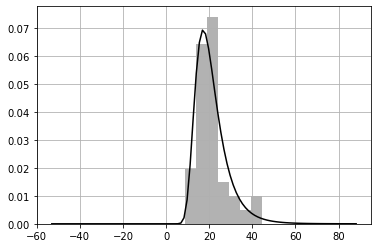

In [19]:
# for histogram



plt.hist(block_max_era, 7,
         density=True,
         histtype='bar',
         facecolor='k',
         alpha=0.3)


shape_era, loc_era, scale_era = gev.fit(block_max_era)
xx_era = np.linspace(loc_era - (scale_era / shape_era), loc_era + (scale_era / shape_era), num=100)
yy_era = gev.pdf(xx_era, shape_era, loc_era, scale_era)

plt.plot(xx_era, yy_era, 'k-')

plt.grid()
plt.show()

In [14]:
whos

Variable        Type              Data/Info
-------------------------------------------
block_max_era   DataArray         <xarray.DataArray 'tp' (y<...> 2015 2016 2017 2018 2019
data            str               era
datetime        module            <module 'datetime' from '<...>b/python3.9/datetime.py'>
directory       str               /net/pc170547/nobackup_2/users/sager/ERA5/
files           str               /net/pc170547/nobackup_2/<...>day/era5_????0[678]_tp.nc
gev             genextreme_gen    <scipy.stats._continuous_<...>object at 0x7f4977bcab50>
lat             int               52
lon             int               5
mpatches        module            <module 'matplotlib.patch<...>s/matplotlib/patches.py'>
np              module            <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
plt             module            <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
preprocess      function          <function preprocess at 0x7f49775ee8b0>
preprocessERA   func

In [7]:
del ds_era

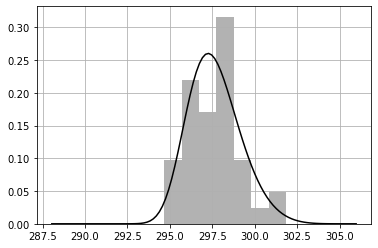

In [20]:
# for histogram



plt.hist(block_max_era, 7,
         density=True,
         histtype='bar',
         facecolor='k',
         alpha=0.3)


shape_era, loc_era, scale_era = gev.fit(block_max_era)
xx_era = np.linspace(loc_era - (scale_era / shape_era), loc_era + (scale_era / shape_era), num=100)
yy_era = gev.pdf(xx_era, shape_era, loc_era, scale_era)

plt.plot(xx_era, yy_era, 'k-')

plt.grid()
plt.show()

In [8]:
# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(block_max_era)+1]*1.0 #must *1.0 to convert int to float

In [9]:
Nmax = max(N)

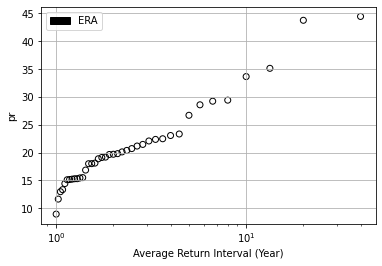

In [21]:
N    = np.r_[1:len(block_max_era)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('pr')



plt.scatter(Nmax/N, sorted(block_max_era)[::-1], color = 'k', facecolors='none', label='ERA')
 
green_patch = mpatches.Patch(color='k', label='ERA') 
plt.legend(handles=[green_patch])

plt.grid()
plt.show()


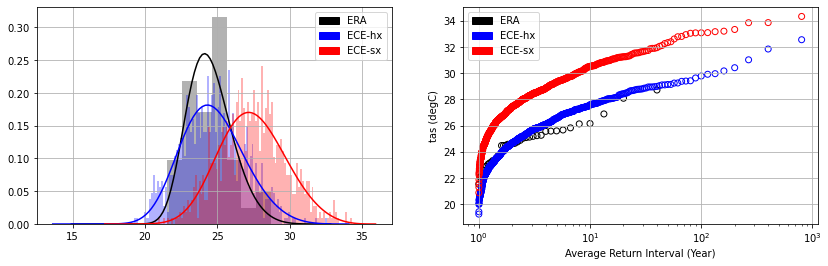

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [100]:
# make a figure with hist to the left, and GEV to the right. 
# figsize 7 of 14, to fit on the page (or half a page)

# ============================ fig specs
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))

k_patch = mpatches.Patch(color='k', label='ERA') 
b_patch = mpatches.Patch(color='b', label='ECE-hx')
r_patch = mpatches.Patch(color='r', label='ECE-sx')


# ============================ left figure
#plt.xlabel('pr (mm/day)')

ax1.legend(handles=[k_patch,b_patch,r_patch])
#ax1.grid()

# ERA
block_max_era_day=unit_converter*block_max_era-273.15
ax1.hist(block_max_era_day, 7,
         density=True,
         histtype='bar',
         facecolor='k',
         alpha=0.3)

shape_era, loc_era, scale_era = gev.fit(block_max_era_day)
xx_era = np.linspace(loc_era - (scale_era / shape_era), loc_era + (scale_era / shape_era), num=100)
yy_era = gev.pdf(xx_era, shape_era, loc_era, scale_era)

ax1.plot(xx_era, yy_era, 'k-')
ax1.grid()

# hx
block_max_hx_day=unit_converter*block_max_hx-273.15
ax1.hist(block_max_hx_day, 100,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.3)

shape_hx, loc_hx, scale_hx = gev.fit(block_max_hx_day)
xx_hx = np.linspace(loc_hx - (scale_hx / shape_hx), loc_hx + (scale_hx / shape_hx), num=100)
yy_hx = gev.pdf(xx_hx, shape_hx, loc_hx, scale_hx)

ax1.plot(xx_hx, yy_hx, 'b-')

# sx
block_max_sx_day=unit_converter*block_max_sx-273.15
ax1.hist(block_max_sx_day, 100,
         density=True,
         histtype='bar',
         facecolor='r',
         alpha=0.3)

shape_sx, loc_sx, scale_sx = gev.fit(block_max_sx_day)
xx_sx = np.linspace(loc_sx - (scale_sx / shape_sx), loc_sx + (scale_sx / shape_sx), num=100)
yy_sx = gev.pdf(xx_sx, shape_sx, loc_sx, scale_sx)

ax1.plot(xx_sx, yy_sx, 'r-')



# ============================ right figure

# axes specs 
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('tas (degC)')
ax2.legend(handles=[k_patch,b_patch,r_patch])
ax2.grid()

# draw extreme values from observations(empirical distribution)
# era
N    = np.r_[1:len(block_max_era_day)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)
ax2.scatter(Nmax/N, sorted(block_max_era_day)[::-1], color = 'k', facecolors='none', label='era')
 

# hx
N    = np.r_[1:len(block_max_hx_day)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)
ax2.scatter(Nmax/N, sorted(block_max_hx_day)[::-1], color = 'b', facecolors='none', label='hx')

# sx
N    = np.r_[1:len(block_max_sx_day)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)
ax2.scatter(Nmax/N, sorted(block_max_sx_day)[::-1], color = 'r', facecolors='none', label='sx')

plt.show()

In [ ]:
# do this for precip

/usr/people/muntjewe/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)
/usr/people/muntjewe/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)


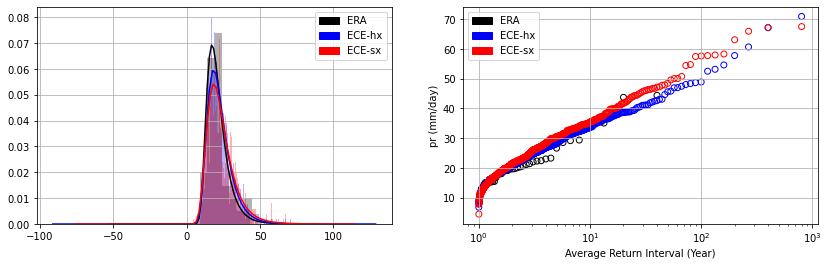

In [81]:
# make a figure with hist to the left, and GEV to the right. 
# figsize 7 of 14, to fit on the page (or half a page)

# ============================ fig specs
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))

k_patch = mpatches.Patch(color='k', label='ERA') 
b_patch = mpatches.Patch(color='b', label='ECE-hx')
r_patch = mpatches.Patch(color='r', label='ECE-sx')

# ============================ convert units: per second to per day
s2day=60*60*24

# ============================ left figure
#plt.xlabel('pr (mm/day)')

ax1.legend(handles=[k_patch,b_patch,r_patch])
#ax1.grid()

# ERA
ax1.hist(block_max_era, 7,
         density=True,
         histtype='bar',
         facecolor='k',
         alpha=0.3)

shape_era, loc_era, scale_era = gev.fit(block_max_era)
xx_era = np.linspace(loc_era - (scale_era / shape_era), loc_era + (scale_era / shape_era), num=100)
yy_era = gev.pdf(xx_era, shape_era, loc_era, scale_era)

ax1.plot(xx_era, yy_era, 'k-')
ax1.grid()

# hx
block_max_hx_day=unit_converter*block_max_hx
ax1.hist(block_max_hx_day, 100,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.3)

shape_hx, loc_hx, scale_hx = gev.fit(block_max_hx_day)
xx_hx = np.linspace(loc_hx - (scale_hx / shape_hx), loc_hx + (scale_hx / shape_hx), num=100)
yy_hx = gev.pdf(xx_hx, shape_hx, loc_hx, scale_hx)

ax1.plot(xx_hx, yy_hx, 'b-')

# sx
block_max_sx_day=unit_converter*block_max_sx
ax1.hist(block_max_sx_day, 100,
         density=True,
         histtype='bar',
         facecolor='r',
         alpha=0.3)

shape_sx, loc_sx, scale_sx = gev.fit(block_max_sx_day)
xx_sx = np.linspace(loc_sx - (scale_sx / shape_sx), loc_sx + (scale_sx / shape_sx), num=100)
yy_sx = gev.pdf(xx_sx, shape_sx, loc_sx, scale_sx)

ax1.plot(xx_sx, yy_sx, 'r-')



# ============================ right figure

# axes specs 
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('pr (mm/day)')
ax2.legend(handles=[k_patch,b_patch,r_patch])
ax2.grid()

# draw extreme values from observations(empirical distribution)
# era
N    = np.r_[1:len(block_max_era)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)
ax2.scatter(Nmax/N, sorted(block_max_era)[::-1], color = 'k', facecolors='none', label='era')
 

# hx
N    = np.r_[1:len(block_max_hx_day)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)
ax2.scatter(Nmax/N, sorted(block_max_hx_day)[::-1], color = 'b', facecolors='none', label='hx')

# sx
N    = np.r_[1:len(block_max_sx_day)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)
ax2.scatter(Nmax/N, sorted(block_max_sx_day)[::-1], color = 'r', facecolors='none', label='sx')

plt.show()

In [ ]:
# make a figure with hist to the left, and GEV to the right. 
# figsize 7 of 14, to fit on the page (or half a page)

## next steps: 
# include also hxxx and sxxx
# make it a python script
# save the figures (export them somewhere)